In [1]:
from sklearn.linear_model import LogisticRegression

from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy,
)

from obp.policy import IPWLearner, Random
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR,
)

/Volumes/SSD-PSMU3/GitHub/example-open-bandit-pipeline/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 人工データの生成

p.87

生成データフォーマット

- `n_rounds`: データ数
- `n_actions`: 意思決定モデルが選択できる行動の数
- `context`: 各データに対する特徴量
- `action_context`: 行動を表現するone-hotベクトル
- `action`: 過去の意思決定モデル`pi_b`によって選択された行動
- `reward`: 過去の意思決定モデル`pi_b`によって選択された行動に対する報酬
- `expected_reward`: 各行動に対する報酬の期待値。因果推論モデルで最終的に得たい情報
- `pscore`: 過去の意思決定モデル`pi_b`による行動選択確率

In [2]:
dataset = SyntheticBanditDataset(
    n_actions=3,
    dim_context=5,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)

In [3]:
training_data = dataset.obtain_batch_bandit_feedback(n_rounds=10000)
validation_data = dataset.obtain_batch_bandit_feedback(n_rounds=10000)

In [4]:
training_data

{'n_rounds': 10000,
 'n_actions': 3,
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [-1.27028221,  0.80914602, -0.45084222,  0.47179511,  1.89401115],
        [-0.68890924,  0.08857502, -0.56359347, -0.41135069,  0.65157486],
        [ 0.51204121,  0.65384817, -1.98849253, -2.14429131, -0.34186901]]),
 'action_context': array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 'action': array([2, 1, 0, ..., 0, 0, 2]),
 'position': None,
 'reward': array([0, 1, 1, ..., 0, 1, 1]),
 'expected_reward': array([[0.90550599, 0.63788051, 0.07940653],
        [0.92452392, 0.84562223, 0.25208537],
        [0.69851411, 0.50998591, 0.07404111],
        ...,
        [0.98848873, 0.93172544, 0.16875497],
        [0.93408855, 0.65101561, 0.39983279],
        [0.82463779, 0.24446592, 0.75860861

In [5]:
training_data["action_context"].tolist()

[[1, 0, 0], [0, 1, 0], [0, 0, 1]]

In [6]:
set(training_data["reward"].tolist())

{0, 1}

In [7]:
validation_data

{'n_rounds': 10000,
 'n_actions': 3,
 'context': array([[ 0.43473651,  0.28892246, -0.80945479,  1.59442032,  0.86886285],
        [ 0.40338143, -0.47894608, -0.06737703, -2.65932054, -0.83837731],
        [ 2.47244458,  0.59674369,  0.61911426, -0.20459904,  0.14098079],
        ...,
        [ 1.42408759,  0.43832029,  1.60780305, -0.27684065, -1.41350158],
        [-0.65257593, -1.4938017 , -0.66387424,  0.68710758, -1.25823339],
        [-1.02877579,  0.40254317, -0.24025777,  0.22296652, -1.10929397]]),
 'action_context': array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 'action': array([2, 1, 0, ..., 0, 0, 2]),
 'position': None,
 'reward': array([0, 0, 0, ..., 0, 1, 1]),
 'expected_reward': array([[0.9957313 , 0.98496983, 0.57728875],
        [0.13346901, 0.01509507, 0.6312733 ],
        [0.68350644, 0.4603164 , 0.64775476],
        ...,
        [0.5674272 , 0.25620438, 0.94997752],
        [0.96964232, 0.82302469, 0.901332  ],
        [0.98041991, 0.82988144, 0.95507121

## 意思決定モデルの学習

p.90

In [8]:
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, random_state=12345),
)

In [9]:
ipw_learner.fit(
    context=training_data["context"],
    action=training_data["action"],
    reward=training_data["reward"],
    pscore=training_data["pscore"],
)

In [10]:
action_choice_by_ipw_learner = ipw_learner.predict(
    context=validation_data["context"]
)

In [11]:
action_choice_by_ipw_learner

array([[[0.],
        [1.],
        [0.]],

       [[1.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [1.]],

       [[1.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [1.]]])

### ランダム行動

In [12]:
# 比較のためにランダムに行動を選択する
random = Random(n_actions=dataset.n_actions, random_state=12345)

# バリデーションデータに対して行動選択確率を計算する -> これはランダムなので、行動選択確率は一様分布
action_choice_by_random = random.compute_batch_action_dist(
    n_rounds=validation_data["n_rounds"]
)

## 意思決定モデルの性能を評価する

p.92

In [13]:
# DR推定量を用いるために必要な目的変数予測モデルを構築する
# opeモジュールに実装されているRegressionModelに好みの機械学習モデルを渡すことで、目的変数予測モデルを構築できる
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    base_model=LogisticRegression(C=100, random_state=12345),
)

# fit_predictメソッドを用いることで、構築した目的変数予測モデルを用いて、バリデーションデータに対する期待報酬を推定できる
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=validation_data["context"],
    action=validation_data["action"],
    reward=validation_data["reward"],
    n_folds=3,
    random_state=12345,
)

In [14]:
estimated_rewards_by_reg_model

array([[[0.97784801],
        [0.90777582],
        [0.9140003 ]],

       [[0.36767396],
        [0.12236525],
        [0.13924521]],

       [[0.81234159],
        [0.48930046],
        [0.50719788]],

       ...,

       [[0.84216585],
        [0.56129532],
        [0.59750201]],

       [[0.94070907],
        [0.79185876],
        [0.81529846]],

       [[0.96404902],
        [0.86541046],
        [0.88180353]]])

In [15]:
# 意思決定モデルの性能評価を一気通貫で行うためのOffPolicyEvaluationを定義する
ope = OffPolicyEvaluation(
    bandit_feedback=validation_data,
    ope_estimators=[IPS(), DR()],   # 意思決定モデルの性能評価に用いるOPE推定量を指定する
)

### 可視化

/Volumes/SSD-PSMU3/GitHub/example-open-bandit-pipeline/.venv/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Volumes/SSD-PSMU3/GitHub/example-open-bandit-pipeline/.venv/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


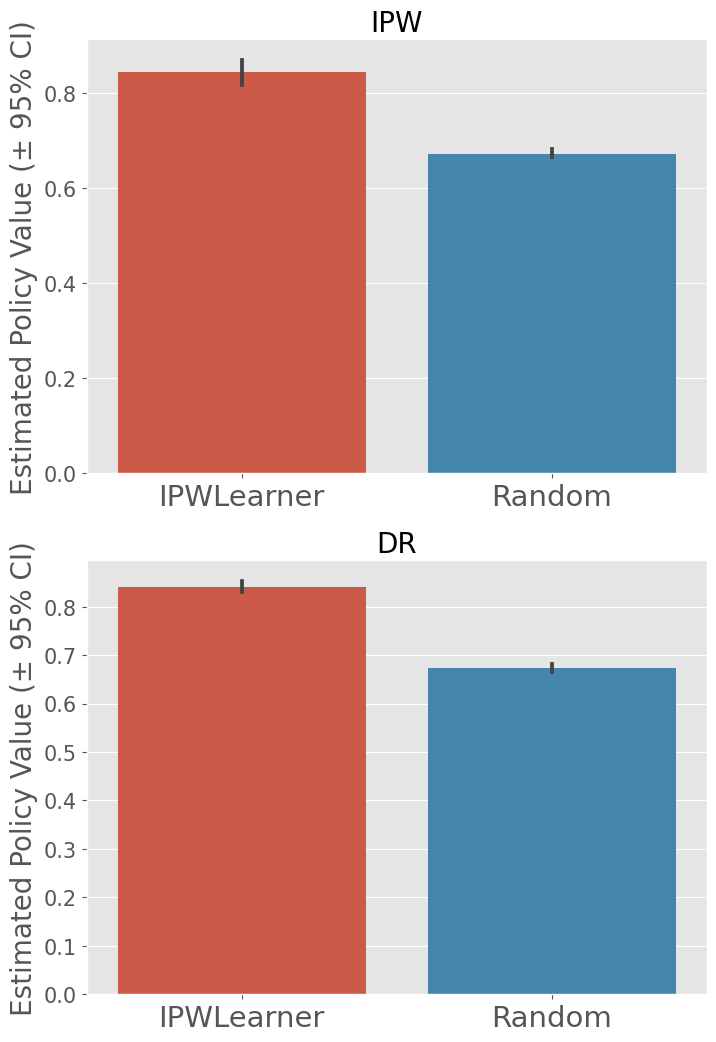

In [16]:
# IPWLearner + ロジスティック回帰の性能をIPS推定量とDR推定量で評価する
ope.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["IPWLearner", "Random"],   # 比較する意思決定モデルの名前
    action_dist_list=[
        action_choice_by_ipw_learner,   # IPWLearnerの行動選択確率
        action_choice_by_random,   # ランダムな行動選択確率
    ],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,   # 目的変数予測モデルによる期待報酬の推定値
    random_state=12345,
)

### 真の性能評価

通常はexpected_rewardを知らないので、上記のように因果推論モデルで推定する

In [17]:
# IPWLearnerとrandomの真の性能を計算する
performance_of_ipw_learner = dataset.calc_ground_truth_policy_value(
    expected_reward=validation_data["expected_reward"],
    action_dist=action_choice_by_ipw_learner,
)
performance_of_random = dataset.calc_ground_truth_policy_value(
    expected_reward=validation_data["expected_reward"],
    action_dist=action_choice_by_random,
)

print("Performance of IPWLearner:", performance_of_ipw_learner)
print("Performance of Random:", performance_of_random)

Performance of IPWLearner: 0.8363312686688807
Performance of Random: 0.6766063835071588
